In [ ]:
import numpy as np
from itertools import permutations

class Stats:
    def __init__(self) -> None:
        self.fitness_history = []
        self.network = None
        self.fitness = None

# Define the comparator function
def comparator(x, y):
    if x > y:
        return y, x
    else:
        return x, y
    
def num_of_comparators(network):
    return sum(map(lambda t: t[-1], network))

# Define the initial sorting network topology
def init_network(n):
    network = []
    for i in range(n):
        for j in range(i+1, n):
            network.append((i, j, True))
    return network

# Apply a sorting network on a given input data set.
def apply_network(network, data):
    sorted_data = data.copy()
    for i, j, used in network:
        if used:
            sorted_data[i], sorted_data[j] = comparator(sorted_data[i], sorted_data[j])
    return sorted_data

def count_errors(network, input):
    ground_truth = np.sort(input)
    sorted_input = apply_network(network, input)
    return sum(1 for i in range(len(input)) if sorted_input[i] != ground_truth[i])

def test_max_n_cases(network, data, n):
    if np.math.factorial(len(data)) > n:
        return np.array([count_errors(network, input=np.random.permutation(data)) for _ in range(int(n))])
    else:
        return np.array([count_errors(network, np.array(permutation)) for permutation in list(permutations(data))])

# Define the fitness function to optimize the number of comparators used in the sorting network
def fitness(network, data, max_tests):
    errors = sum(test_max_n_cases(network, data, max_tests))
    fitness = num_of_comparators(network) + 10*errors**2
    return fitness

def mutate(network, prob):
    return list(map(lambda t: (t[0], t[1], not t[2]) if np.random.random() < prob else t, network))

# Define the cooling schedule function
def exponential_temperature(T0, cooling_rate):
    """Generator for exponential temperature function"""
    T = T0
    while True:
        yield T
        T = T0 * np.exp(-cooling_rate * T)

# Define the cooling schedule function
def power_temperature(T0, cooling_rate, p):
    """Generator for power temperature function"""
    t = 0
    while True:
        yield T0 / (1 + cooling_rate * t ** p)
        t += 1

# Define the cooling schedule function
def cooling_schedule(T, alpha):
    while True:
        yield T
        T *= alpha

# Define the simulated annealing function
def simulated_annealing(data, T0, p, alpha, mutation_prob, num_of_tests, max_iterations):
    stats = Stats()
    # Initialize the current solution and temperature
    current_network = init_network(len(data))
    current_fitness = fitness(current_network, data, num_of_tests)
    T = T0
    # Initialize the best solution and fitness seen so far
    best_network = current_network
    best_fitness = current_fitness
    # Initialize the cooling schedule generator
    schedule = cooling_schedule(T, alpha)
    # Run the simulated annealing loop
    for i in range(max_iterations):
        # Generate a new solution by randomly swapping two comparators in the current network
        new_network = list(current_network)
        i, j = np.random.choice(range(len(new_network)), 2, replace=False)
        new_network[i], new_network[j] = new_network[j], new_network[i]
        new_network = mutate(new_network, mutation_prob)
        # Evaluate the fitness of the new solution
        new_fitness = fitness(new_network, data, num_of_tests)
        # Determine whether to accept the new solution or not based on the acceptance probability
        delta_fitness = new_fitness - current_fitness
        if delta_fitness < 0 or np.random.random() < np.exp(-delta_fitness / T):
            current_network = new_network
            current_fitness = new_fitness
        # Update the best solution seen so far
        if current_fitness < best_fitness:
            best_network = current_network
            best_fitness = current_fitness
        # Update the temperature according to the cooling schedule
        T = next(schedule)
        # Stats
        stats.fitness_history.append(best_fitness)
    stats.network = best_network
    stats.fitness = best_fitness
    return stats


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from typing import List

def best_error_fitness_history(runs, storage_path):
  best = min(runs, key=lambda x:x.fitness)
  print("Best sorting network:", best.network)
  print("Fitness:", best.fitness)
  print("Num of comparators:", num_of_comparators(best.network))

  results = test_max_n_cases(best.network, data, max_final_tests)
  all = len(results)
  errors = results[results != 0]
  invalid = len(errors)
  valid = len(results) - invalid
  errors_sum = sum(errors)
  accuracy = valid/all
  error = 1 - accuracy
  mean_error = np.mean(errors) if len(errors) > 0 else 0

  fig, ax = plt.subplots(figsize=(12.8, 7.2), dpi=100)
  bars, counts = np.unique(errors, return_counts=True)
  print(bars, counts)
  plt.bar(bars, counts, alpha=0.6)
  plt.xticks(bars, bars)
  textstr = '\n'.join((
      f"presnosť = {round(accuracy,3)}",
      f"chyba = {round(error,3)}",
      f'nesprávnych = {invalid}',
      f"priemerná \nveľkosť chyby = {round(mean_error, 3)}"))

  props = dict(boxstyle='round', facecolor='white', alpha=0.3)
  plt.text(0.832, 0.98, textstr, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, bbox=props)
  plt.xlabel("chyby")
  plt.ylabel("permutácie")
  fig.savefig(os.path.join(storage_path, "all_errors.png"))

  fig = plt.figure(figsize=(12.8, 7.2), dpi=100)
  plt.plot(best.fitness_history)
  fig.savefig(os.path.join(storage_path, "best_fitness_history.png"))

def fitness_history_graph(runs, storage_path):
  fitness_history_runs = np.array([run.fitness_history for run in runs])

  mins = np.min(fitness_history_runs, axis=0)
  meds = np.median(fitness_history_runs, axis=0)
  maxs = np.max(fitness_history_runs, axis=0)
  var = np.var(fitness_history_runs, axis=0)

  fig = plt.figure(figsize=(12.8, 7.2), dpi=100)
  x = np.arange(1,max_iterations+1)
  plt.xscale('log')
  plt.plot(x,meds, label="median")
  plt.plot(x,mins, label="minimum")
  plt.fill_between(x,mins,maxs,alpha=0.4)
  plt.fill_between(x,meds-var,meds+var,alpha=0.2)
  plt.legend()
  plt.xlabel("počet iterácií")
  plt.ylabel("fitness")
  fig.savefig(os.path.join(storage_path, "fitness_history.png"))

def plot_graphs(runs, storage_path):
  best_error_fitness_history(runs, storage_path)
  fitness_history_graph(runs, storage_path)

def run_mul_runs(num_of_runs, storage_path, name) -> List[Stats]:
    storage_path = os.path.join(storage_path, name)
    if not os.path.exists(storage_path):
        os.mkdir(storage_path)
    runs = []
    for i in range(num_of_runs):
        runs.append(simulated_annealing(data, T0, p, alpha, mutation_prob, max_tests, max_iterations))
        np.save(os.path.join(storage_path, "runs.npy"), np.array(runs))
        print(i+1, end=". ", flush=True)
    plot_graphs(runs, storage_path)
    print()
    return runs

def boxplot_graph(runs_to_compare, storage_path):
  fig = plt.figure(figsize=(12.8, 7.2), dpi=100)
  plt.boxplot([np.array([run.fitness for run in runs]) for runs in runs_to_compare], notch=True)
  plt.savefig(os.path.join(storage_path, "boxplot.png"))
    

data = np.arange(1,16)
n = len(data)
T0 = 100.0
p = 2
alpha = 0.95
mutation_prob = 0.005
max_iterations = 10000
max_tests = 100
max_final_tests = 1e4

storage_path="/content/stats"
if not os.path.exists(storage_path):
        os.mkdir(storage_path)


1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. Best sorting network: [(1, 10, True), (0, 2, True), (1, 9, True), (0, 4, True), (5, 6, True), (7, 11, True), (1, 6, True), (0, 5, True), (1, 8, True), (12, 14, True), (6, 11, False), (4, 10, True), (0, 13, True), (3, 14, False), (5, 9, True), (2, 11, False), (7, 8, True), (2, 14, True), (7, 14, False), (0, 3, True), (2, 6, True), (8, 14, True), (0, 9, False), (4, 11, True), (5, 11, True), (4, 14, True), (7, 13, True), (1, 7, True), (2, 4, True), (2, 5, True), (2, 13, True), (1, 14, False), (3, 8, True), (1, 5, True), (2, 3, True), (3, 13, True), (4, 6, True), (1, 12, True), (2, 8, True), (9, 13, True), (13, 14, True), (0, 12, True), (4, 8, True), (0, 11, False), (7, 9, True), (0, 1, True), (3, 5, True), (2, 7, True), (2, 9, True), (3, 9, False), (3, 7, True), (4, 9, True), (4, 7, True), (3, 6, False), (2, 12, True), (5, 10, True), (4, 12, True), (0, 8, False), (8, 11, True), (

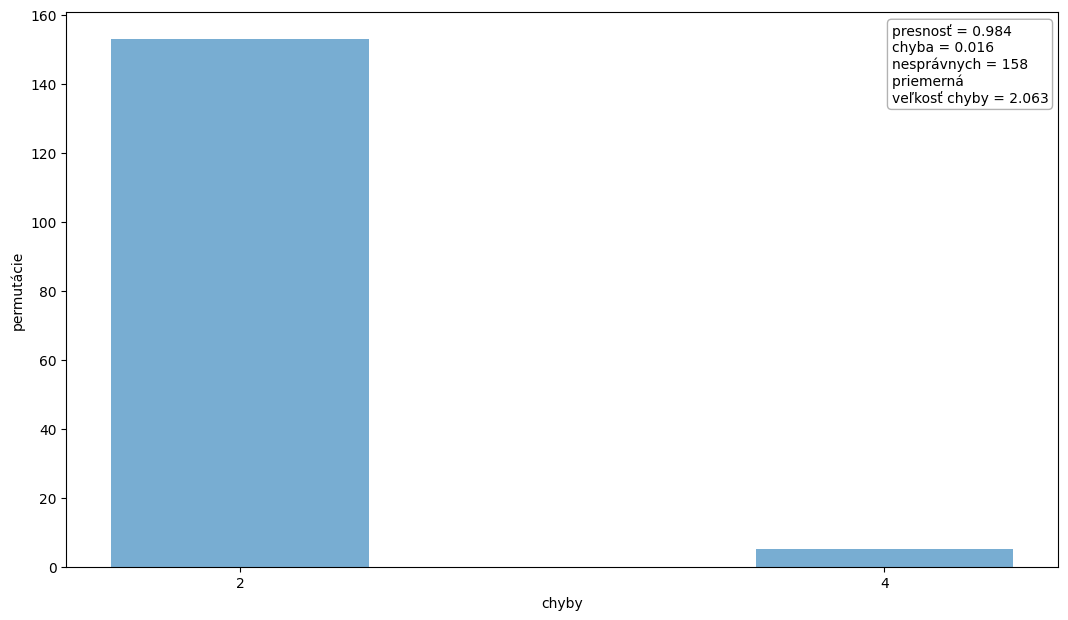

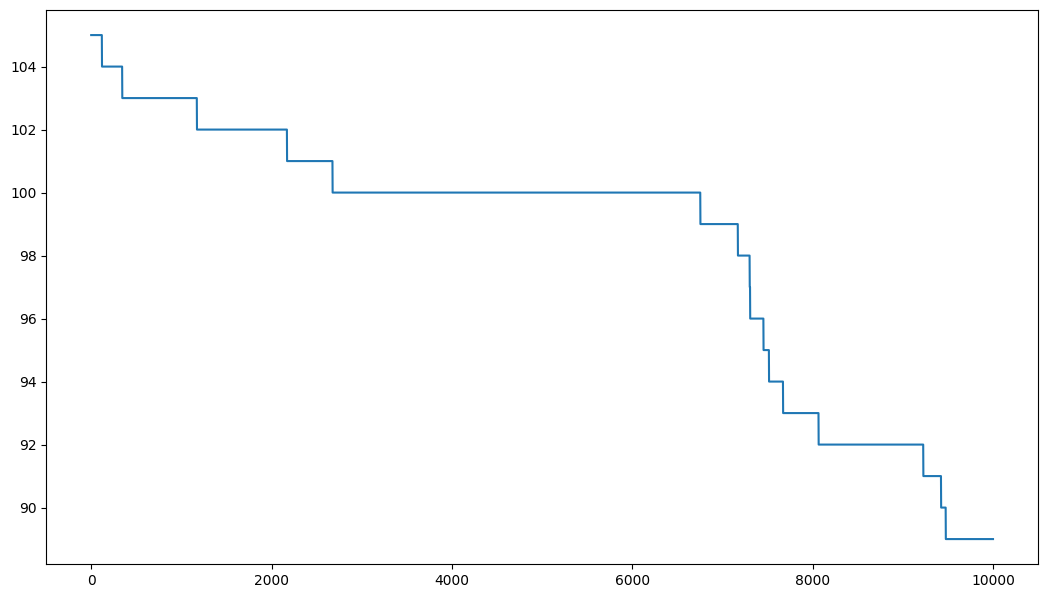

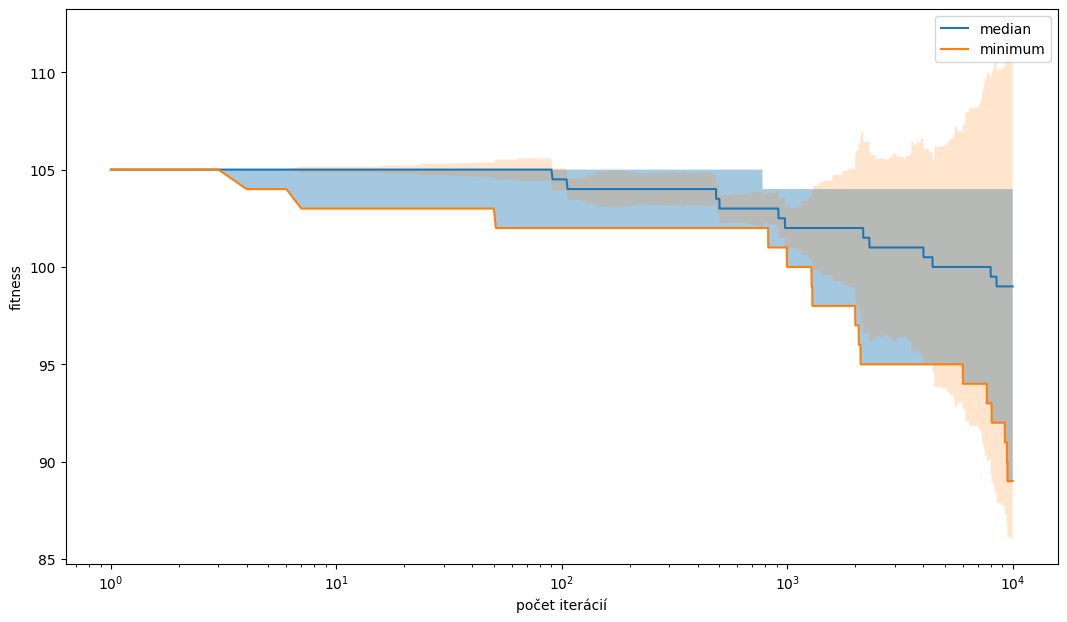

In [ ]:
mutation_prob = 0.005
run1 = run_mul_runs(30, storage_path, "run005")
!cp -R stats/run005 drive/MyDrive/VUT/EVO/mutation5-col/run005

1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. Best sorting network: [(6, 14, True), (2, 8, True), (1, 9, True), (5, 12, True), (4, 13, True), (1, 10, True), (0, 3, True), (4, 14, True), (5, 14, False), (4, 12, True), (4, 7, True), (2, 14, True), (10, 12, True), (11, 13, True), (5, 9, True), (3, 8, True), (2, 13, True), (0, 8, True), (7, 9, True), (8, 9, True), (3, 11, False), (10, 14, True), (2, 10, True), (8, 12, True), (6, 9, True), (1, 14, True), (0, 6, True), (1, 6, True), (7, 11, True), (1, 4, True), (10, 13, True), (8, 14, True), (12, 14, True), (1, 11, False), (3, 6, True), (2, 6, True), (3, 10, True), (5, 11, True), (0, 9, True), (6, 13, True), (3, 14, True), (2, 9, True), (3, 7, True), (0, 4, True), (8, 11, True), (0, 5, True), (7, 12, True), (2, 7, True), (1, 7, True), (0, 2, True), (7, 13, True), (9, 13, True), (6, 12, True), (8, 10, True), (1, 3, True), (2, 5, True), (0, 11, True), (4, 10, True), (6, 10, True)

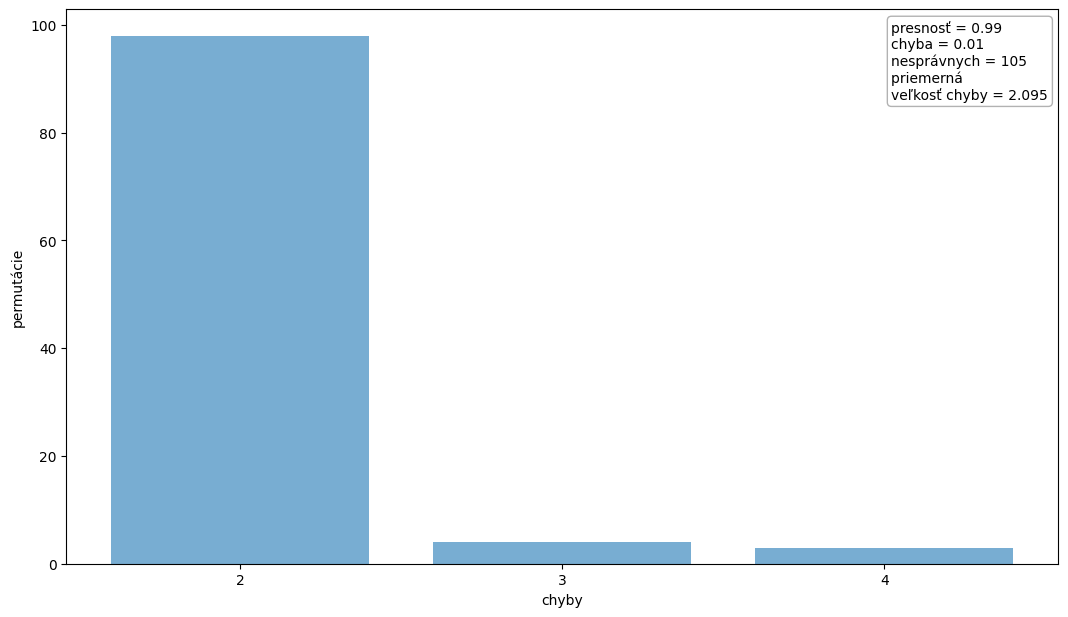

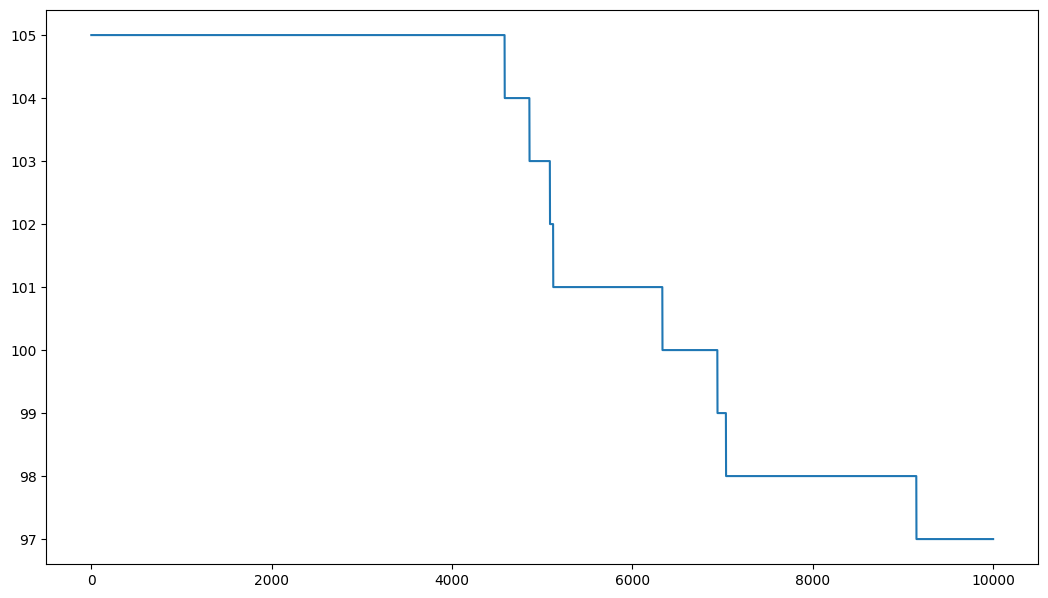

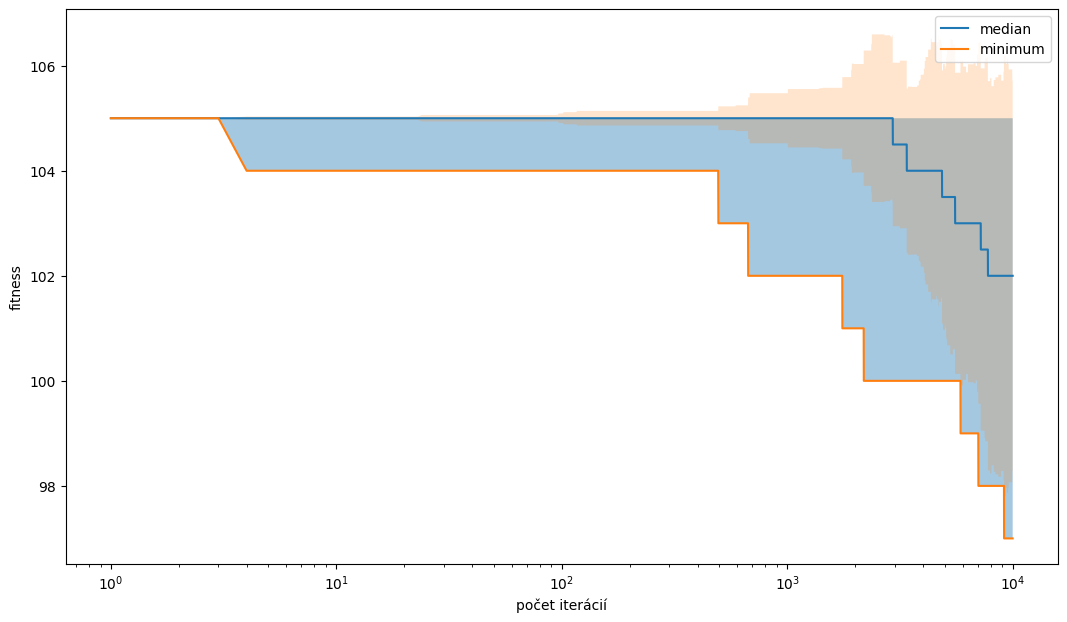

In [ ]:
mutation_prob = 0.0005
run2 = run_mul_runs(30, storage_path, "run0005")
!cp -R stats/run0005 drive/MyDrive/VUT/EVO/mutation5-col/run0005

1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. Best sorting network: [(0, 8, True), (3, 4, True), (1, 6, True), (0, 4, True), (6, 8, True), (5, 7, True), (3, 7, True), (1, 14, True), (1, 4, True), (1, 9, True), (5, 6, True), (3, 6, True), (0, 5, True), (4, 7, True), (0, 10, True), (3, 8, True), (0, 3, True), (1, 13, True), (0, 14, True), (1, 11, True), (9, 10, True), (0, 6, True), (1, 5, True), (2, 4, True), (2, 10, True), (3, 5, True), (0, 2, True), (0, 7, True), (1, 8, False), (2, 5, True), (2, 6, True), (2, 7, True), (6, 10, True), (2, 9, True), (1, 3, True), (2, 11, True), (2, 8, True), (2, 13, True), (1, 7, True), (2, 14, True), (0, 1, True), (0, 12, True), (1, 2, True), (0, 9, True), (4, 6, True), (1, 12, True), (3, 11, True), (4, 8, True), (3, 9, True), (3, 14, True), (5, 9, True), (2, 12, True), (0, 13, True), (3, 12, True), (7, 8, True), (3, 13, True), (4, 11, True), (2, 3, True), (4, 13, True), (4, 9, True), (4, 

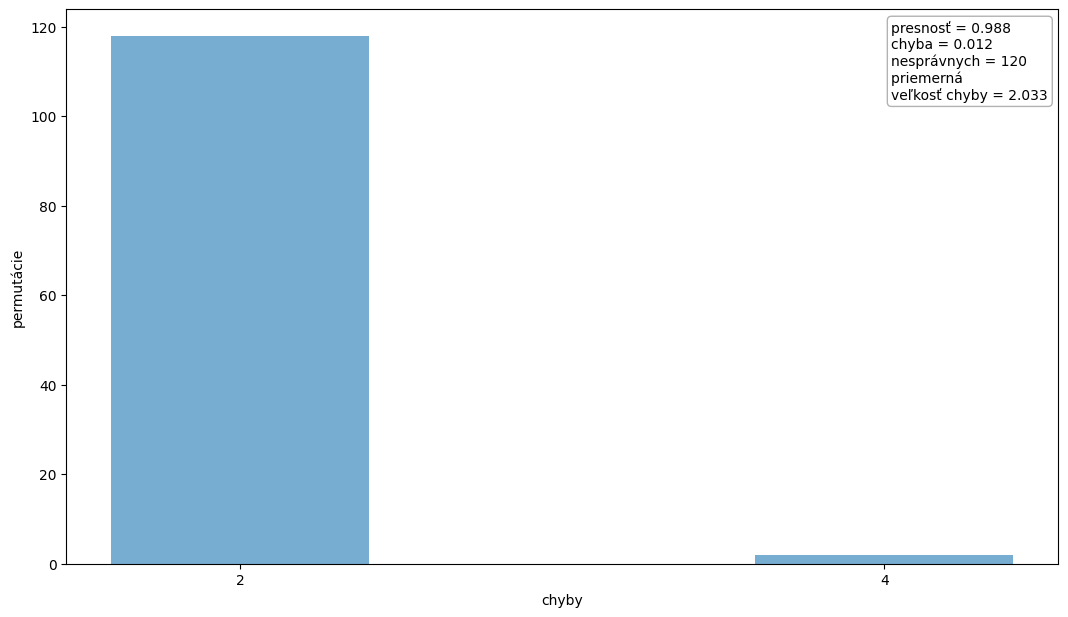

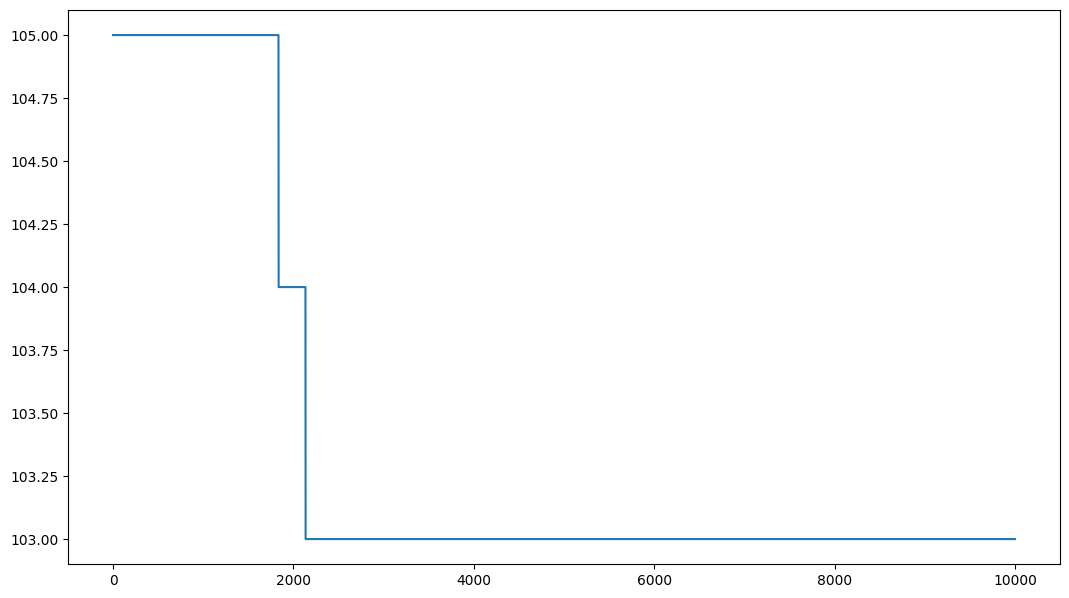

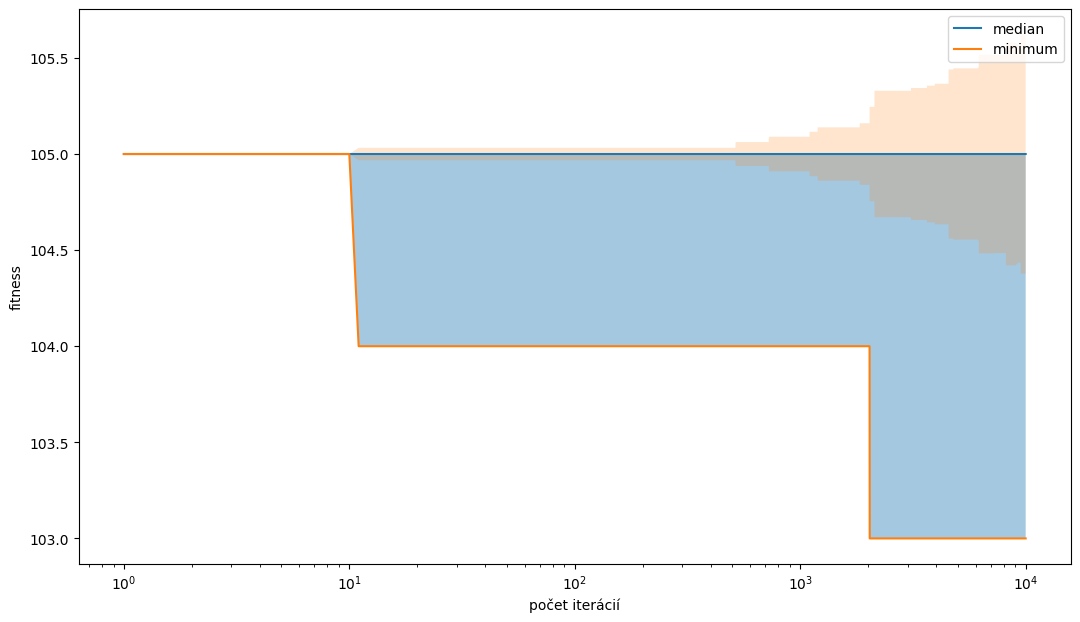

In [ ]:
mutation_prob = 0.00005
run3 = run_mul_runs(30, storage_path, "run00005")
!cp -R stats/run00005 drive/MyDrive/VUT/EVO/mutation5-col/run00005

cp: cannot create directory 'drive/MyDrive/VUT/EVO/mutation5-col/box': No such file or directory


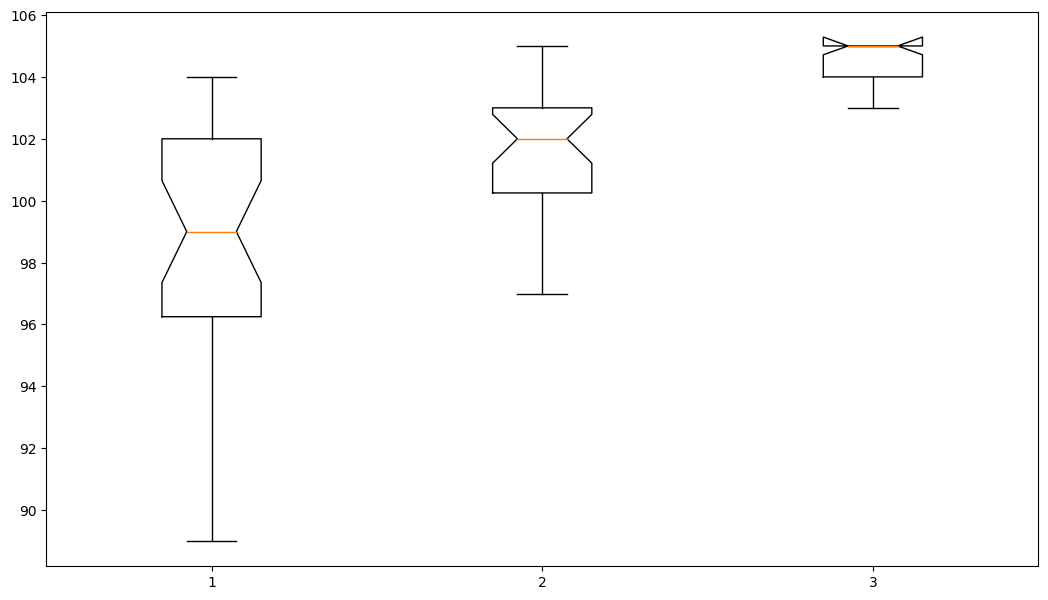

In [ ]:
boxplot_graph([run1, run2, run3], storage_path)
!cp -R stats drive/MyDrive/VUT/EVO/mutation5-col/box

In [ ]:
!cp -R stats drive/MyDrive/VUT/EVO/mutation5-col/box

1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. Best sorting network: [(0, 1, True), (0, 2, True), (0, 3, True), (0, 4, True), (0, 5, True), (0, 6, True), (0, 7, True), (0, 8, True), (1, 5, True), (0, 10, True), (0, 11, True), (0, 12, True), (0, 13, True), (0, 14, True), (1, 2, True), (1, 3, True), (1, 4, True), (0, 9, True), (1, 6, True), (1, 9, True), (1, 8, True), (1, 7, True), (1, 10, True), (1, 11, True), (1, 12, True), (1, 13, True), (1, 14, True), (2, 3, True), (2, 4, True), (2, 5, True), (2, 6, True), (2, 7, True), (2, 8, True), (2, 10, True), (2, 9, True), (2, 11, True), (2, 12, True), (2, 13, True), (2, 14, True), (3, 4, False), (3, 5, True), (3, 6, True), (3, 7, True), (3, 8, True), (3, 9, True), (3, 10, True), (3, 11, True), (3, 12, True), (3, 13, True), (3, 14, True), (4, 5, False), (4, 6, True), (4, 7, True), (4, 8, True), (4, 9, True), (4, 10, True), (4, 11, True), (4, 12, True), (4, 13, True), (5, 10, True),

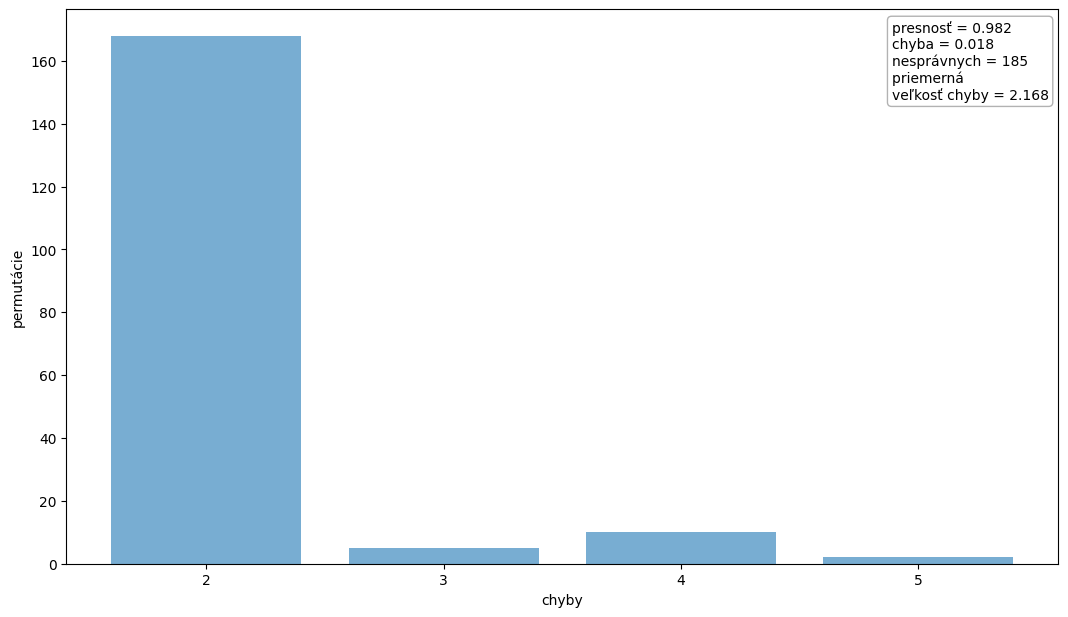

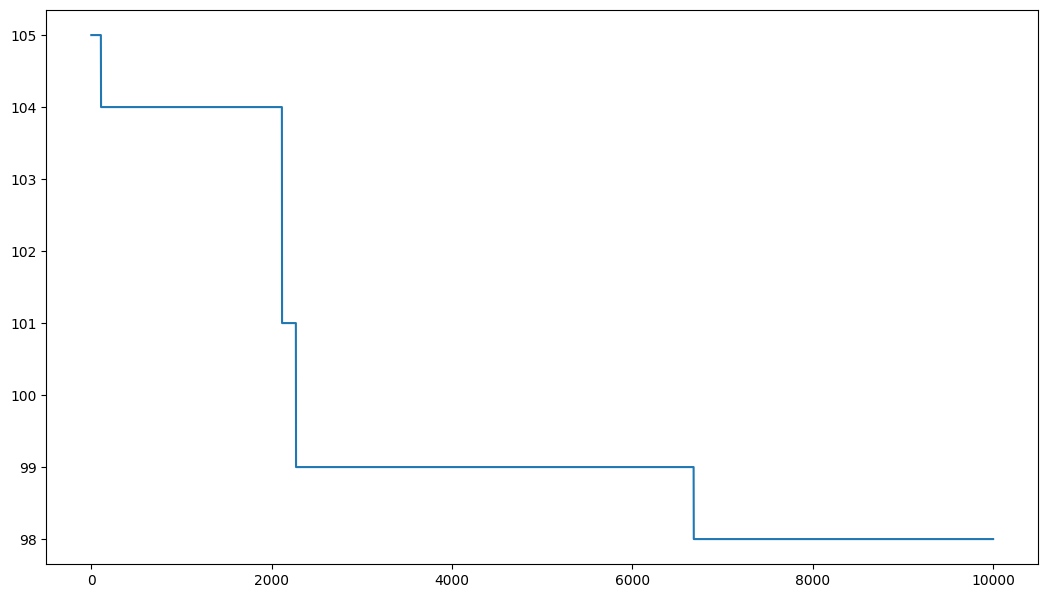

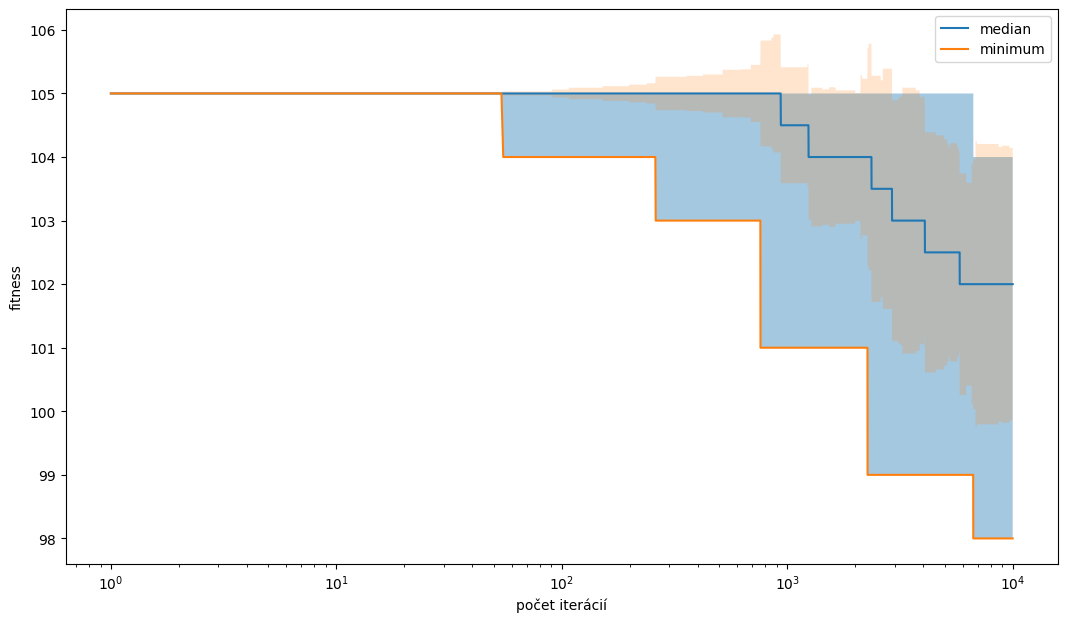

In [ ]:
mutation_prob = 0.05
run3 = run_mul_runs(30, storage_path, "run05")
!cp -R stats/run05 drive/MyDrive/VUT/EVO/mutationB-col/run05

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import permutations

class Stats:
    def __init__(self) -> None:
        self.fitness_history = []
        self.network = None
        self.fitness = None

storage_path="/content/stats"
if not os.path.exists(storage_path):
        os.mkdir(storage_path)


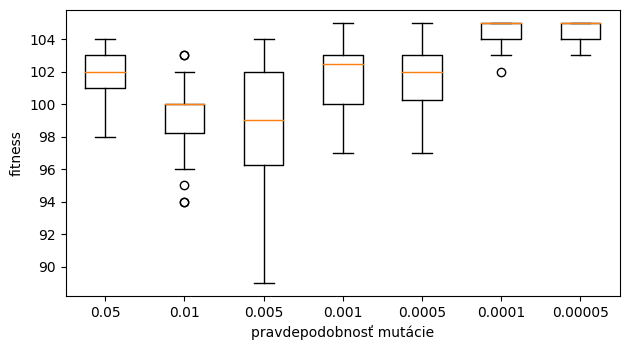

In [9]:
r01 = np.load("drive/MyDrive/VUT/EVO/mutation1-col/run01/runs.npy", allow_pickle=True)
r001 = np.load("drive/MyDrive/VUT/EVO/mutation1-col/run001/runs.npy", allow_pickle=True)
r0001 = np.load("drive/MyDrive/VUT/EVO/mutation1-col/run0001/runs.npy", allow_pickle=True)
r005 = np.load("drive/MyDrive/VUT/EVO/mutation5-col/run005/runs.npy", allow_pickle=True)
r0005 = np.load("drive/MyDrive/VUT/EVO/mutation5-col/run0005/runs.npy", allow_pickle=True)
r00005 = np.load("drive/MyDrive/VUT/EVO/mutation5-col/run00005/runs.npy", allow_pickle=True)
r05 = np.load("drive/MyDrive/VUT/EVO/mutationB-col/run05/runs.npy", allow_pickle=True)

def boxplot_graph(runs_to_compare, storage_path):
  fig = plt.figure(figsize=(12.8/2, 7.2/2), dpi=100)
  plt.boxplot([np.array([run.fitness for run in runs]) for runs in runs_to_compare])
  plt.xticks(np.arange(1, len(runs_to_compare)+1), ["0.05","0.01","0.005","0.001","0.0005","0.0001","0.00005"])
  plt.xlabel("pravdepodobnosť mutácie")
  plt.ylabel("fitness")
  plt.tight_layout()
  plt.savefig(os.path.join(storage_path, "boxplot-wo_notch-s.pdf"), format="pdf")

boxplot_graph([r05,r01,r005,r001,r0005,r0001,r00005], storage_path)

!cp -R stats drive/MyDrive/VUT/EVO/mutationB-col/box